In [1]:
from collections import Counter
from tqdm import tqdm 
from colorama import Style,Fore
import os
from utils1 import openJson,saveJson
from dotenv import load_dotenv
import json
import time
load_dotenv()

True

# With Embedding model

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("dangvantuan/sentence-camembert-base")

In [ ]:
from sentence_transformers import util

def calculateSimilarity(videoMD, documents):
    embedding_video = model.encode([videoMD], convert_to_tensor=True, normalize_embeddings=True)
    embeddings_documents = model.encode(documents, convert_to_tensor=True, normalize_embeddings=True)
    scores = util.cos_sim(embedding_video, embeddings_documents)[0]
    simScore = scores.mean().item()
    return simScore


In [ ]:
Vocabulary = openJson("../jsons/Voc.json")

def construire_groupes(mots_cles, taille=25):
    phrases = []
    for i in range(0, len(mots_cles), taille):
        groupe = mots_cles[i:i+taille]
        phrase = ' '.join(groupe)
        phrases.append(phrase)
    return phrases

documents = construire_groupes(Vocabulary)

In [ ]:
print(len(documents))
print(documents[7])

## Test

In [ ]:
requete = """
On a testé la cuisinière à bois... Vous connaissez?
🙋‍♂️Et vous, vous êtes-vous déjà servi d'une cuisinière à bois? Avez-vous des conseils à nous donner pour garantir son utilisation et la sécurité inhérente à cet appareil ancestral? ❔\n\n➕La cuisinière à bois, c'était clairement un bonus qu'on n'avait mis dans nos préférences en visitant la maison. On connaissait certains de ses avantages, mais en l'utilisant pour la première fois, non seulement on a été conquis, mais cette expérience a révélé de nombreux points positifs qu'on ignorait. On vous raconte tout ça dans cette nouvelle vidéo! \n\n🙅‍♂️J'ai oublié d'évoquer un des avantages dans cette vidéo: PRENDRE LE TEMPS! C'est tellement bon de prendre plus de temps pour faire sensiblement la même chose!\n\n✍️On a hâte d'avoir vos retours. Depuis cette vidéo, on est retournés une fois à nos fourneaux pour fêter la Thanksgiving canadienne, et on a définitivement adopté ce nouveau compagnon de route! En plus de tous les avantages cités dans cette vidéo, c'est ultra convivial!\n\n😎 Si c'est votre première fois, bienvenue sur notre chaîne. Ici on va parler autonomie bien sûr, mais transition en général, que ce soit vers des nouveaux modes de consommation, vers d'autres manières de voyager, vers un vivre-ensemble qui a du sens. En famille ou sans, c'est pareil, on est dans le même bateau.\n\nBonne vidéo, merci de nous soutenir en vous abonnant et à très vite dans les commentaires!\n\n00:00 On n'y connaissait rien\n01:12 On présente le four (avant utilisation)\n02:55 Premier essai: Pain...\n05:37 ... et plein d'autres trucs (on optimise)\n06:54 On a adoré cette première expérience!\n07:50 On déguste. Vous venez?\n\n( ͡❛ ᴗ ͡❛)✊ LA FAMILLE EN TRANSITION\n\n❤ Abonne-toi à la Chaîne pour ne rater aucune vidéo https://www.youtube.com/channel/UC2M77RNyW6O9JQhpj1-6GOA\n✌ Laisse-nous un pouce bleu si la vidéo t'a plue\n\nContacte-nous à lafamilleentransition@gmail.com",
 "#lafamilleentransition",
      "#LFET",
      "#Florian Guéret",
      "#Cuisinière à bois",
      "#comment cuisiner avec une cuisinière à bois",
      "#bois de chauffage",
      "#cuisiner comme au bon vieux temps",
      "#cuisiner à l'ancienne",
      "#cuisine",
      "#cuisiner au feu de bois",
      "#cuisine moderne",
      "#cuisine traditionnelle",
      "#transition",
      "#entransition",
      "#la famille",
      "#vlog famille",
      "#vlog",
      "#bretagne",
      "#pontivy",
      "#à l'abri de la pluie",
      "#comment cuisiner du pain",
      "#comment faire son pain en cocotte",
      "#faire son pain en baguette"
"""


calculateSimilarity(requete,documents)

## Echantillon

In [ ]:
videosF2 = openJson("../jsons/videosF2.json")
len(videosF2)

In [ ]:
import random

random.seed(42)

echantillon = random.sample(videosF2, 400)
saveJson("../jsons/echantillon.json",echantillon)

## Run and Results 

In [ ]:
echantillon = openJson("../jsons/echantillon.json")
len(echantillon)

In [ ]:
approach_1_Results = []
for video in tqdm(echantillon):
    context = video['titre_video'] + video['description'] + ' '.join(video['tags'])
    score = calculateSimilarity(context,documents)
    #print(score,'  ',video['id_video'])
    video.update({'similarity':score})
    approach_1_Results.append(video)

saveJson("../jsons/approach_1_Results.json",approach_1_Results)

- Analyzing

In [ ]:
approach_1_Results = openJson("../jsons/approach_1_Results.json")
len(approach_1_Results)

In [ ]:
sum_similarities = 0 
for item in approach_1_Results :
    sum_similarities+=item['similarity']
    
sum_similarities/len(approach_1_Results)

In [ ]:
similarites = [item["similarity"] for item in approach_1_Results]

nombre_total = len(similarites)
nombre_sup_015 = sum(s > 0.15 for s in similarites)
pourcentage_sup_015 = (nombre_sup_015 / nombre_total) * 100

print(f"Nombre de vidéos avec similarité > 0.15 : {nombre_sup_015}")
print(f"Pourcentage : {pourcentage_sup_015:.2f}%")


In [ ]:
videos_sous_015 = [item for item in approach_1_Results if item["similarity"] <= 0.15]
videos_sous_015 = sorted(videos_sous_015, key=lambda x: x["similarity"])

videos_sur_015 = [item for item in approach_1_Results if item["similarity"] > 0.15]
videos_sur_015 = sorted(videos_sur_015, key=lambda x: x["similarity"])

In [ ]:
for vi_sous_015 in videos_sous_015:
    print(f"ID vidéo: {vi_sous_015['id_video']} - Similarité: {vi_sous_015['similarity']:.2f}")

In [ ]:
for videos_sur_015 in videos_sur_015:
    print(f"ID vidéo: {videos_sur_015['id_video']} - Similarité: {videos_sur_015['similarity']:.2f}")

# With LLM

In [ ]:
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
gemini_flash_1 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_1"))
gemini_flash_2 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_2"))
gemini_flash_3 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_3"))

In [ ]:
sysprompt = """
# La définition d’autosuffisance

L'autosuffisance est la démarche visant à acquérir la capacité de subvenir par soi-même à ses besoins fondamentaux, 
en premier lieu alimentaires par l'autoconsommation – c'est-à-dire produire, récolter et conserver un maximum de sa propre nourriture, 
souvent en privilégiant le bio, le local et le saisonnier. 

L'autosuffisance Plus qu'une simple recherche d'autonomie matérielle, elle représente un engagement pour être moins dépendant du système économique et social extérieur, impliquant des choix concrets comme trouver un lieu propice et le concevoir judicieusement (par exemple en permaculture), 
ainsi qu'un changement dans la manière de valoriser son temps et de consommer, formant ainsi le fondement d'une vie plus autonome.

---

# Votre mission

- Décider si une vidéo concerne la thématique de l'autosuffisance en se basant sur ses métadonnées (titre, description, tags).  
- Les vlogs, les interviews et les vidéos de partage d'expériences en lien avec l'autosuffisance sont intéressants.  
- Les tutoriels et les vidéos de conseils sont également pertinents.  
- Les vidéos présentant une technique liée à l'autosuffisance ou y contribuant sont utiles.  
- Attribuer un score entier de 1 à 10 pour évaluer la pertinence de la vidéo par rapport à la thématique de l'autosuffisance.

---

# Votre réponse  

- La réponse doit être au format JSON :  
  
    "decision": "oui ou non",
    "justification": "Justifiez votre décision avec des arguments"
    "score": votre èvaluation
 
"""

userprompt = """
Titre
---
{titre}
Description
---
{description}
tags
---
{tags}
"""

prompt = ChatPromptTemplate([
    ("system", sysprompt),
    ("user", userprompt)
])

chain_1 = prompt | gemini_flash_1
chain_2 = prompt | gemini_flash_2
chain_3 = prompt | gemini_flash_3


## Test

In [ ]:
input = {"titre":"Tuteurer et redresser un arbre 🌳",
         "description":"Dans cette vidéo nous allons voir ensemble comment mettre un tuteur afin de redresser un arbre qui penche suite à la tempête.\nCette vidéo vous aideras pour placer un tuteur en travers , sangler un arbre selon le sens du vent,\n\nIl existe plusieurs facon de tuteurer un arbre, haubanage, tripode,.. mais dans le cas présent un tuteur en biais suffiras puisque l'arbre n'est pas trés gros.\n\n\n▬▬▬▬▬▬▬▬▬▬▬ POUR ALLER PLUS LOIN  ▬▬▬▬▬▬▬▬▬▬▬\n\n💡 Abonnez-vous pour me soutenir 🧡\n\n\n💡Rejoignez-nous sur twitter\net tik tok\n\n\n▬▬▬▬▬▬▬▬▬▬▬ CHAPITRES DE CETTE VIDÉO ▬▬▬▬▬▬▬▬▬▬\n\n00:00 : Introduction\n00:23 : Mise en place tuteur\n01:54 : Sanglage et Redresser l'arbre\n02:54 : Sens du vent et détails tuteurage\n\n▬▬▬▬▬▬▬▬▬▬▬ A PROPOS DE CETTE VIDÉO ▬▬▬▬▬▬▬▬▬▬▬\n\nLe Jardin du moulin\nFrancois\n#potager #jardindumoulin",
         "tags":', '.join( [
      "TCS",
      "Agriculture Biologique",
      "Bio",
      "GAB 85",
      "FNAB",
      "Vendée",
      "Techniques Culturales Simplifiées",
      "GAEC Les Jonquilles",
      "ECOPHYTO",
      "Demain Vendée",
      "Conservation des sols",
      "Sol vivant",
      "Productions végétales",
      "Maïs"
    ])}
print(input)
print(chain_1.invoke(input))

## Run and Results 

In [ ]:
def cleanAnswer(answer):
    answer = answer.strip("`")   
    if answer.startswith("json"):
        answer = answer[4:].strip() 
    return  answer

In [ ]:
echantillon = openJson("../jsons/echantillon.json")
approach_2_Results = []
count1 = 0
count2 = 0
temp = 0

for video in tqdm(echantillon):
    input = {"titre":video['titre_video'],
             "description":video['description'],
             "tags":', '.join(video['tags']),}
    try:
        if count1  <= 13:
            print("KEY 1")
        
            answer = cleanAnswer(chain_1.invoke(input))
            #print(video['id_video'],'/n',answer)
            video.update(json.loads(answer))
            approach_2_Results.append(video)
            
            count1+=1
            temp+=1            
             
            print("count1 ",count1)  
            
        if count1  > 13 and count2 <= 13:
            print("KEY 2")
            
            answer = cleanAnswer(chain_2.invoke(input))
            #print(video['id_video'],'/n',answer)
            video.update(json.loads(answer))
            approach_2_Results.append(video)
            
            count2+=1
            temp+=1
            print("count2 ",count2)  
            
        if count1 > 13 and count2 > 13 :
            print("sleep for 1 min")
            time.sleep(60)
            count1 = 0
            count2 = 0
        

        if temp >= 100:
            saveJson("../jsons/approach_2_Results.json",approach_2_Results)
            temp=0
            
    except Exception as e:
        print(f"error {e}")

## Validate the llmResults

### Validate the pertinent videos

In [ ]:
channels = openJson("../../../collecting/jsons/channels.json")
llmVideosOui = openJson("../jsons/llmVideosOui.json")

print(len(channels))
print(len(llmVideosOui))

In [ ]:
def getChannelName(ID):
    for channel in channels:
        if channel['id_chaine']==ID:
            return channel['nom_chaine'] 

In [ ]:
llmVideosOui_channelnames = []
for videoOui in llmVideosOui:
    llmVideosOui_channelnames.append(getChannelName(videoOui['id_chaine']))
    
namesCounter = Counter(llmVideosOui_channelnames)    

In [ ]:
namesCounter

len(namesCounter)

In [ ]:
namesCounter

In [ ]:
valideChannels = ["L'ArchiPelle",
                  'Ver de Terre Production',
                  'Atelier Fertile',
                  'Nature-Simple.com',
                  'Scop Terre vivante',
                  'Rustica',
                  'La clé des champs',
                  'permaculture agroécologie etc...',
                  'Permaculture Design',
                  'Julien Malara',
                  'Ecolobionature Isabelle B.',
                  "La p'tite ortie dans la prairie",
                  'Björn Duval',
                  'PERMAFUTUR TV',
                  'Destination Bonheur',
                  "Le potager d'Olivier",
                  'Chez Picro',
                  'Pierre1911',
                  "Le Jardin d'Emerveille",
                  "L' AUTONOMIE DU BONHEUR",
                  "Permacult' Urbaine",
                  'Devenir Autosuffisant par Robert RIVIERE',
                  'Loic Vauclin (Le Jardineur)',
                    'fredo brico',
                    'Edenguard',
                    'Xavier Mathias',
                    'Nouvelle Graine',
                    'Lakaban Autonome',
                    'La Ferme de Cagnolle',
                     'Avenir Permaculture',
                   'Alexandre Leroux',
                            
                  ]

len(valideChannels)

In [ ]:
count = 0
for videoOui in llmVideosOui:
    if getChannelName(videoOui['id_chaine']) in valideChannels:
        videoOui['validation']='oui'
        count+=1
    else :
        videoOui['validation']=''
print(count)

In [ ]:
saveJson("../jsons/llmVideosOui.json",llmVideosOui)

In [ ]:
ToValidate = []
for videoOui in llmVideosOui:
    if videoOui['validation']=='':
        videoOui['lien']= f"https://www.youtube.com/watch?v={videoOui['id_video']}"
        ToValidate.append(videoOui)
   
saveJson("../jsons/ToValidate.json",ToValidate)        
print(len(ToValidate))

In [ ]:
ToValidate = openJson("../jsons/ToValidate.json")
validations = []
for val in ToValidate:
    validations.append(val['validation'])
    
validationsCounter = Counter(validations)
validationsCounter

- Reintegrate the ToValidate into llmVideosOui.json

In [ ]:
ToValidate = openJson("../jsons/ToValidate.json")
llmVideosOui = openJson("../jsons/llmVideosOui.json")

for videoOui in llmVideosOui:
    if videoOui['validation']=='':
        for tt in ToValidate:
            if tt['id_video']==videoOui['id_video']:
                videoOui['validation']=tt['validation']
        
saveJson("../jsons/llmVideosOui.json",llmVideosOui)

In [ ]:
finalResults = []
for videoOui in llmVideosOui:
    finalResults.append(videoOui['validation'])

finalResultsCounter = Counter(finalResults)
finalResultsCounter

### Validate the non pertinent videos

In [ ]:
llmVideosNon = openJson("../jsons/llmVideosNon.json")
len(llmVideosNon)

In [ ]:
for videoNon in llmVideosNon:
    videoNon['lien']= f"https://www.youtube.com/watch?v={videoNon['id_video']}"
    videoNon['validation']=''

saveJson("../jsons/llmVideosNon.json",llmVideosNon)

In [ ]:
finalResults = []
for videoNon in llmVideosNon:
    finalResults.append(videoNon['validation'])

finalResultsCounter = Counter(finalResults)
finalResultsCounter

In [ ]:
TP = 285
FP = 65
FN = 2
TN = 48

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy : {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall   : {recall:.2%}")
print(f"F1-score : {f1_score:.2%}")


### groundTruth for the next steps

In [ ]:
llmVideosNon = openJson("../jsons/llmVideosNon.json")
llmVideosOui = openJson("../jsons/llmVideosOui.json")
videosF2 = openJson("../jsons/videosF2.json")

def getVideo(ID):
    for v in videosF2:
        if v['id_video']==ID:
            return v

print(len(videosF2))
print(len(llmVideosNon),' ',len(llmVideosOui))



In [ ]:
groundTruth = []

for video in llmVideosNon:
    v = getVideo(video['id_video'])
    v['pertinente'] = video['validation']
    groundTruth.append(v)
    
for video in llmVideosOui:
    v = getVideo(video['id_video'])
    v['pertinente'] = video['validation']
    groundTruth.append(v)  
      
len(groundTruth)

In [ ]:
saveJson("../jsons/groundTruth.json",groundTruth)

# Number of search queries

## nbrQueries 

In [ ]:
channels = openJson("../../../collecting/jsons/channels.json")
len(channels)

In [ ]:
queriesCounter = []
for video in videosF2:
    for channel in channels:
        if channel['id_chaine'] == video['id_chaine']:
            channelname = channel['nom_chaine']
    queriesCounter.append({
        'id_video': video['id_video'],
        'numQueries': len(video['requete']),
        'channelname': channelname
    })

queriesCounter = sorted(queriesCounter, key=lambda x: x['numQueries'], reverse=True)

total_queries = sum(item['numQueries'] for item in queriesCounter)
nombre_videos = len(queriesCounter)
moyenne_queries = total_queries / nombre_videos

print(queriesCounter[:5])
print(moyenne_queries)

- La moyenne de **nbrQueries** pour les vidéos non pertinentes.

In [ ]:
groundTruth = openJson("../jsons/groundTruth.json")

In [ ]:
queriesCounterNon = []
queriesCounterOui = []

for video in groundTruth:
    if video['pertinente']=='oui':
        queriesCounterOui.append(len(video['requete']))
    else:
        queriesCounterNon.append(len(video['requete']))

print(len(queriesCounterOui))
print(len(queriesCounterNon))

In [ ]:
print(f'Moyenne de nbrQueries pour les vidéos non pertinentes : {sum(queriesCounterNon)/len(queriesCounterNon)}')
print(f'Moyenne de nbrQueries pour les vidéos  pertinentes : {sum(queriesCounterOui)/len(queriesCounterOui)}')

=> nbrQueries est un bon indicateur de pertinence des videos.

## Indice de pertinence

I.P = llmScore × α + numQueries × β

- On teste au depart avec alpha= 0.7 et beta = 0.3 sur notre echantillon 

### les IP pour echantillon

In [ ]:
approach_2_Results = openJson("../jsons/approach_2_Results.json")
echantillon = openJson("../jsons/echantillon.json")

print(len(approach_2_Results))
print(len(echantillon))

In [ ]:
def getEchantillonIP(alpha):
    beta = 1-alpha
    echantillonIP_Results = []
    
    for item in echantillon:
        nbrQueries = len(item['requete'])
        for v in approach_2_Results:
            if v['id_video']==item['id_video']:
                llmScore = v['score']
        itemIP = llmScore*alpha + nbrQueries*beta
        item['IP']=itemIP
        echantillonIP_Results.append(item)
        
    return echantillonIP_Results

In [ ]:
echantillonIP_Results = getEchantillonIP(alpha=0.8)
saveJson("../jsons/echantillonIP_Results.json",echantillonIP_Results)
print(len(echantillonIP_Results))

### Distribution des IP

In [ ]:
echantillonIP_Results = openJson("../jsons/echantillonIP_Results.json")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ip_values = [item['IP'] for item in echantillonIP_Results]

plt.boxplot(ip_values, vert=True)
plt.title('Boxplot des valeurs de IP')
plt.show()

In [ ]:
min_val = np.min(ip_values)
q1 = np.percentile(ip_values, 25)
median = np.median(ip_values)
q3 = np.percentile(ip_values, 75)
max_val = np.max(ip_values)

iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

print(f'Min     = {min_val:.2f}')
print(f'Q1      = {q1:.2f}')
print(f'Median  = {median:.2f}')
print(f'Q3      = {q3:.2f}')
print(f'Max     = {max_val:.2f}')
print(f'IQR     = {iqr:.2f}')
print(f'Limite inférieure des moustaches = {lower_limit:.2f}')
print(f'Limite supérieure des moustaches = {upper_limit:.2f}')


### Choix de alpha et seuil 

In [ ]:
groundTruth = openJson("../jsons/groundTruth.json")

In [ ]:
def getEvaluationMetrics(TP,TN,FP,FN):
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    #print(f"Accuracy : {accuracy:.2%}")
    #print(f"F1-score : {f1_score:.2%}")
    return round(accuracy,2),round(f1_score,2)
    
def getGround(ID):
    for g in groundTruth:
        if g['id_video']==ID:
            return g['pertinente']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def getMetrics(alpha,seuil):
    echantillonIP_Results = getEchantillonIP(alpha)
    totalPositive = 0
    totalNegative = 0
    TP = 0
    TN = 0
    for item in echantillonIP_Results:
        if item['IP'] <= seuil:
            totalNegative+=1
            groundResult = getGround(item['id_video'])
            if groundResult == 'non':
                TN+=1
        else:
            totalPositive+=1
            groundResult = getGround(item['id_video'])
            if groundResult == 'oui':
                TP+=1
    FN = totalNegative-TN
    FP = totalPositive-TP
    
    accuracy,f1_score = getEvaluationMetrics(TP,TN,FP,FN)
    
    #print(f"Accuracy : {accuracy:.2%}")
    #print(f"F1-score : {f1_score:.2%}")
    
    return accuracy,f1_score 

def getalphaVariation(seuil):
    accuracyValues = []
    f1ScoreValues = []
    
    for alpha in np.arange(0, 1.1, 0.1):
        accuracy,f1_score = getMetrics(alpha,seuil)
        accuracyValues.append(accuracy)
        f1ScoreValues.append(f1_score)
        
    ## Plot 
    
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(0, 1.1, 0.1), accuracyValues, marker='o', color='blue', label='Accuracy')
    plt.plot(np.arange(0, 1.1, 0.1), f1ScoreValues, marker='s', color='green', label='F1 Score')
    plt.xlabel('Alpha')
    plt.ylabel('Score')
    plt.title(f'Accuracy et F1 Score en fonction de Alpha (seuil = {seuil})')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def gridSearchAlphaSeuil():
    best_alpha_acc = None
    best_seuil_acc = None
    best_accuracy = 0

    best_alpha_f1 = None
    best_seuil_f1 = None
    best_f1 = 0

    best_alpha_sum = None
    best_seuil_sum = None
    best_sum = 0
    best_sum_accuracy = 0
    best_sum_f1 = 0

    seuils = range(1, 11)
    alphas = np.arange(0, 1.1, 0.1)

    total = len(seuils) * len(alphas)
    pbar = tqdm(total=total, desc="Grid Search")

    for seuil in seuils:
        for alpha in alphas:
            try:
                accuracy, f1_score = getMetrics(alpha, seuil)
                score_sum = accuracy + f1_score

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_alpha_acc = alpha
                    best_seuil_acc = seuil

                if f1_score > best_f1:
                    best_f1 = f1_score
                    best_alpha_f1 = alpha
                    best_seuil_f1 = seuil

                if score_sum > best_sum:
                    best_sum = score_sum
                    best_alpha_sum = alpha
                    best_seuil_sum = seuil
                    best_sum_accuracy = accuracy
                    best_sum_f1 = f1_score

            except:
                print(f"Combinaison impossible : seuil={seuil}, alpha={alpha}")

            pbar.update(1)

    #pbar.close()

    print(f"Meilleure combinaison Accuracy                    : alpha = {best_alpha_acc}, seuil = {best_seuil_acc}, Accuracy = {best_accuracy:.4f}")
    print(f"Meilleure combinaison F1-score                    : alpha = {best_alpha_f1}, seuil = {best_seuil_f1}, F1-score = {best_f1:.4f}")
    print(f"Meilleure combinaison Somme (Accuracy+F1-score)   : alpha = {best_alpha_sum}, seuil = {best_seuil_sum}, Accuracy = {best_sum_accuracy:.4f}, F1-score = {best_sum_f1:.4f}, Somme = {best_sum:.4f}")

    return {
        'accuracy': {'alpha': best_alpha_acc, 'seuil': best_seuil_acc, 'score': best_accuracy},
        'f1_score': {'alpha': best_alpha_f1, 'seuil': best_seuil_f1, 'score': best_f1},
        'sum': {
            'alpha': best_alpha_sum,
            'seuil': best_seuil_sum,
            'accuracy': best_sum_accuracy,
            'f1_score': best_sum_f1,
            'score': best_sum
        }
    }


In [ ]:
gridSearchAlphaSeuil()

# Apply on all videos

## Add previous llm scores

In [ ]:
videosR4 = openJson("../jsons/videosR4.json")
videosR44 = openJson("../jsons/videosR44.json")
llmEvaluations = openJson(r"C:\Users\hp\Downloads\filtering\jsons\llmEvaluation.json")
approach_2_Results = openJson("../jsons/approach_2_Results.json")

print(len(videosR4))
print(len(videosR44))
print(len(llmEvaluations))
print(len(approach_2_Results))

In [ ]:
count = 0
for video in videosR4:
    if 'score' not in video:
        count+=1
count           

### Add 1

In [ ]:
for video in videosR4:
    for ev in llmEvaluations:
        if ev['id_video']== video['id_video']:
            video['score']=ev['score']
     
            
saveJson("../jsons/videosR4.json",videosR4)

### Add 2

In [ ]:
for video in videosR4:
    for ev in approach_2_Results:
        if ev['id_video']== video['id_video']:
            video['score']=ev['score']
     
            
saveJson("../jsons/videosR4.json",videosR4)

### Add 3

In [ ]:
for video in videosR4:
    for ev in videosR44:
        if ev['id_video']== video['id_video']:
            if 'score' in ev:
                video['score']=ev['score']
     
            
saveJson("../jsons/videosR4.json",videosR4)

## Work on the messing scores

- Run the llm function for videos still with non score

In [ ]:
videosR44 = []
for video in videosR4:
    if 'score' not in video:
        videosR44.append(video)
len(videosR44)
saveJson("../jsons/videosR44.json",videosR44)

In [ ]:
count1 = 0
count2 = 0
count3 = 0
temp = 0

for video in tqdm(videosR44):
  
    input = {"titre":video['titre_video'],
            "description":video['description'],
            "tags":', '.join(video['tags']),}
    try:
        if count1  <= 13:
            #print("KEY 1")
        
            answer = cleanAnswer(chain_1.invoke(input))
            answer = json.loads(answer)
            #print(video['id_video'],'/n',answer)
            video['score']=answer['score']
            
            count1+=1
            temp+=1            
            
            #print("count1 ",count1)  
            
        if count1  > 13 and count2 <= 13:
            #print("KEY 2")
            
            answer = cleanAnswer(chain_2.invoke(input))
            answer = json.loads(answer)
            #print(video['id_video'],'/n',answer)
            video['score']=answer['score']
            
            count2+=1
            temp+=1
            #print("count2 ",count2) 
            
        if  count1  > 13 and count2  > 13 and count3 <= 13:
            
            #print("KEY 3")
            
            answer = cleanAnswer(chain_3.invoke(input))
            answer = json.loads(answer)
            #print(video['id_video'],'/n',answer)
            video['score']=answer['score']
            
            count3+=1
            temp+=1
            #print("count3 ",count3) 
                
        if count1 > 13 and count2 > 13 and count3 > 13 :
            print("sleep for 1 min")
            time.sleep(60)
            count1 = 0
            count2 = 0
            count3 = 0
        

        if temp >= 100:
            saveJson("../jsons/videosR44.json",videosR44)
            temp=0
            
    except Exception as e:
        print(f"error {e}")
        
saveJson("../jsons/videosR44.json",videosR44)

## I.P for All videos

In [14]:
def calculateIpAll(videos):
    for video in videos:
        video['IP'] = 0.5*( len(video['requete']) + video['score'] )
    return videos

def filterVideos(videos):
    videosOui = []
    videosNon = []
    for video in videos:
        if video['IP'] > 4 :
            videosOui.append(video) 
        else :
            videosNon.append(video)
            
    print(f"len(videosOui) : {len(videosOui)} : {len(videosOui)/len(videos)} %")
    print(f"len(videosNon) : {len(videosNon)} : {len(videosNon)/len(videos)} %")
    
    saveJson("../jsons/videosF3.json",videosOui) 
    saveJson("../jsons/videosF3Non.json",videosNon) 

In [ ]:
videosR4 = openJson("../jsons/videosR4.json")
videosR4 = calculateIpAll(videosR4)

In [8]:
saveJson("../jsons/videosR4.json",videosR4)


 json saved


In [ ]:
videosR4 = openJson("../jsons/videosR4.json")
filterVideos(videosR4)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


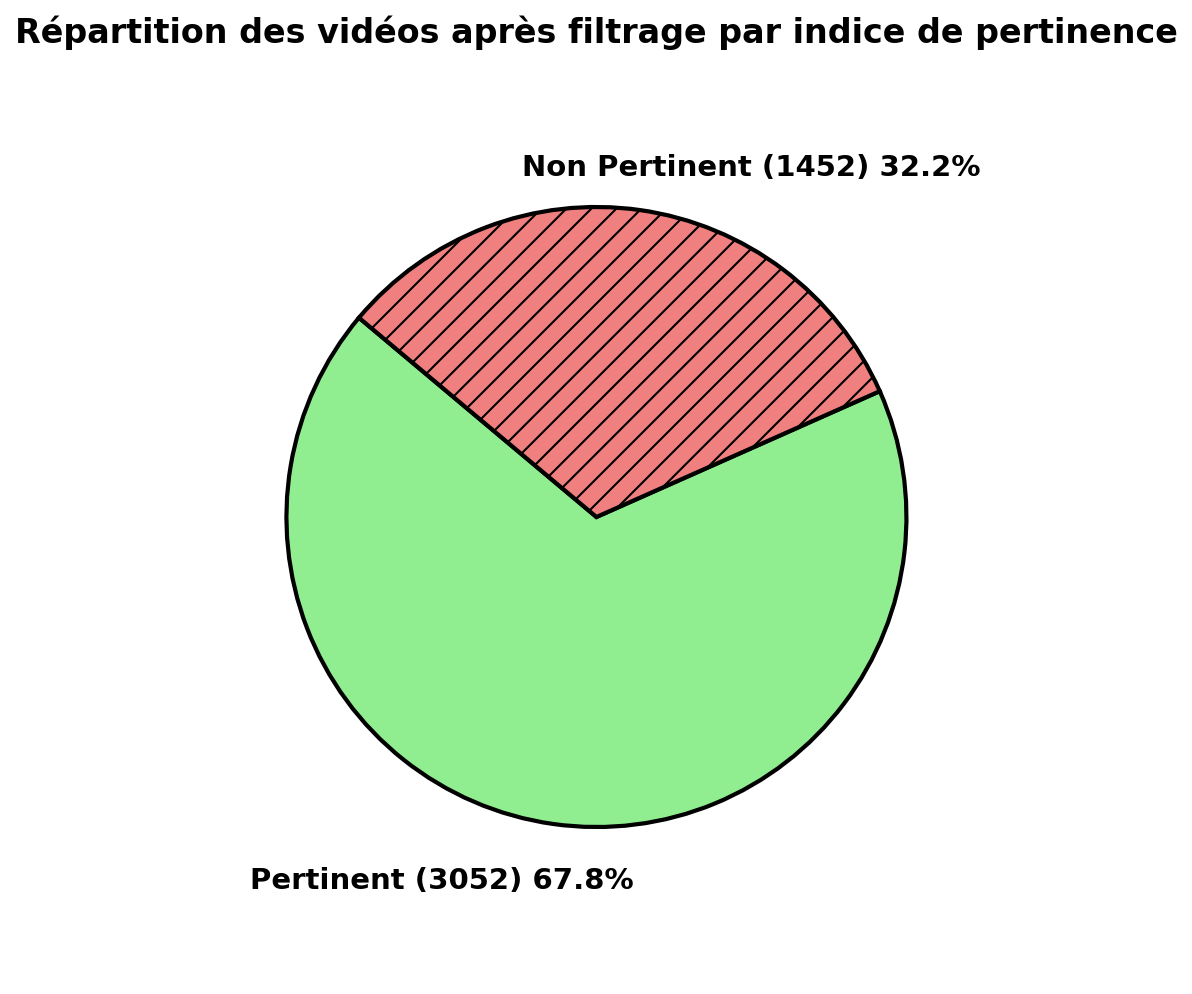

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

labels = ['Oui (Pertinent)', 'Non (Non Pertinent)']
sizes = [3052, 1452]
colors = ['lightgreen', 'lightcoral']
explode = (0, 0.1)

angle_start = 140
angle_non = angle_start + (sizes[0] / sum(sizes)) * 360

fig, ax = plt.subplots(figsize=(8, 8), dpi=150)

w1 = Wedge(center=(0, 0), r=1, theta1=angle_start, theta2=angle_non,
           facecolor='lightgreen', edgecolor='black', lw=2, zorder=5)
w2 = Wedge(center=(0, 0), r=1, theta1=angle_non, theta2=angle_start + 360,
           facecolor='lightcoral', edgecolor='black', hatch='//', lw=2, zorder=5)

ax.add_patch(w1)
ax.add_patch(w2)

ax.text(-0.5, -1.2, f'Pertinent ({sizes[0]}) {sizes[0]/sum(sizes)*100:.1f}%', fontsize=14, ha='center', fontweight='bold', zorder=10)
ax.text(0.5, 1.1, f'Non Pertinent ({sizes[1]}) {sizes[1]/sum(sizes)*100:.1f}%', fontsize=14, ha='center', fontweight='bold', zorder=10)

ax.set_title("Répartition des vidéos après filtrage par indice de pertinence", fontsize=16, fontweight='bold')

ax.axis('equal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.axis('off')

plt.show()


## Excel pour Laura

In [21]:
videosF3 = openJson("../jsons/videosF3.json")
videosF3Non= openJson("../jsons/videosF3Non.json")
len(videosF3)

3052

In [18]:
import pandas as pd

data = []
for video in videosF3:
    lien = f"https://www.youtube.com/watch?v={video['id_video']}"
    titre = video['titre_video']
    description = video['description']
    tags = video['tags']
    score = video['score']
    ip = video['IP']
    data.append({
        "lien": lien,
        "titre": titre,
        "description": description,
        "tags": tags,
        "score": score,
        "IP": ip
    })

df = pd.DataFrame(data)
df.to_excel("../xlsx/videos_pertinentes.xlsx", index=False)


In [19]:
import pandas as pd

data = []
for video in videosF3Non:
    lien = f"https://www.youtube.com/watch?v={video['id_video']}"
    titre = video['titre_video']
    description = video['description']
    tags = video['tags']
    score = video['score']
    ip = video['IP']
    data.append({
        "lien": lien,
        "titre": titre,
        "description": description,
        "tags": tags,
        "score": score,
        "IP": ip
    })

df = pd.DataFrame(data)
df.to_excel("../xlsx/videos_non_pertinentes.xlsx", index=False)
